In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

In [8]:
import json
with open("/content/drive/MyDrive/train.json",'r') as load_f:
     load_dict = json.load(load_f)
with open("/content/drive/MyDrive/test.json",'r') as load_f:
     load_dict_test = json.load(load_f)


In [9]:
#use 80% of it to be the training dataset, rest of it to be validation data
train_len = round(len(load_dict)*0.8)
print('The attribute of data:',load_dict[0].keys())

The attribute of data: dict_keys(['authors', 'year', 'abstract', 'venue', 'title'])


In [10]:
df = pd.DataFrame(load_dict)
df.head()

authors  year                                           abstract  \
0    [42, 13720, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [1359, 15881, 45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2     [19166, 17763]    17  [40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...   
3               [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
4         [19617, 2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   

  venue                                              title  
0    20  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1     2  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2        [2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...  
3     4  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
4     9  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...

# Data Preprocessing

In [11]:
###extract the authors' value & coauthors' value
def co(x):
  x.values[0] = list(filter(lambda i: i>=100, x.values[0]))
  return x
df[['coauthors']] = df[['authors']].apply(lambda x: co(x),axis=1)
len_coauthor = df[['coauthors']].apply(lambda x:len(x.values[0]),axis=1)

def oh(x):
  x.values[0] = list(filter(lambda i: i<100, x.values[0]))
  return x
df[['authors']] = df[['authors']].apply(lambda x: oh(x),axis=1)

df.head()

authors  year                                           abstract venue  \
0  [42, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...    20   
1      [45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...     2   
2        []    17  [40, 1542, 1691, 2449, 1535, 2610, 1543, 1535,...         
3      [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...     4   
4       [2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...     9   

                                               title       coauthors  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...         [13720]  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...   [1359, 15881]  
2  [2085, 1719, 1846, 1745, 2243, 1553, 1606, 159...  [19166, 17763]  
3  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...              []  
4  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...         [19617]

In [12]:
### delete the paper that do not include any prolific author
pro_author = df.apply(lambda x: len(x[0])!=0, axis=1)
pro_author_index = pro_author[pro_author].index
df_pro_author = df.iloc[pro_author_index]

### Copy 10 times of data with prolific author
df_pro_author = pd.concat([df_pro_author,df_pro_author,df_pro_author,df_pro_author,df_pro_author])
df_pro_author = pd.concat([df_pro_author,df_pro_author])
df_pro_author.head()

authors  year                                           abstract venue  \
0  [42, 36]     9  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...    20   
1      [45]    15  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...     2   
3      [97]    10  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...     4   
4       [2]    10  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...     9   
9   [44, 2]    18  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...     0   

                                               title      coauthors  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...        [13720]  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  [1359, 15881]  
3  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...             []  
4  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...        [19617]  
9  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...   [9641, 5623]

In [13]:
df_pro_author.shape

(22380, 6)

In [14]:
non_author = df.apply(lambda x: len(x[0])==0, axis=1)
non_author_index = non_author[non_author].index

### random select 2000 from non-prolific author
# random.seed(2022)
# non_index_random2000 = random.sample(list(non_author_index), 2000) 
# df_non = df.iloc[non_index_random2000]

#### concat data with 10*prolific with non-prolific
df_non = df.iloc[non_author_index]
df_non['authors'] = 101
df = pd.concat([df_pro_author,df_non])
df = df.reset_index().drop(columns = ['index'])
df_y = df[['authors']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  


In [15]:
### Change the value without venue to 465
df['venue'] = df[['venue']].apply(lambda x: x if x.values[0]!='' else 465,axis = 1)

In [ ]:
### one-hot encode for train_y
s = df_y['authors']
y_features = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
y_features = y_features.drop(101, axis=1)

## Plot the distribution of attributes

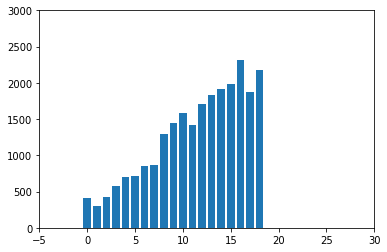

In [16]:
plt.bar(df['year'].value_counts().index,df['year'].value_counts().values)
plt.xlim([-5,30])
plt.ylim([0,3000])
plt.show()

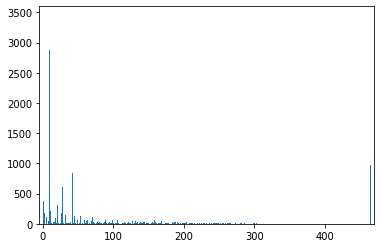

In [17]:
plt.bar(df['venue'].value_counts().index,df['venue'].value_counts().values)
plt.xlim([-5,470])
plt.ylim([0,3600])
plt.show()

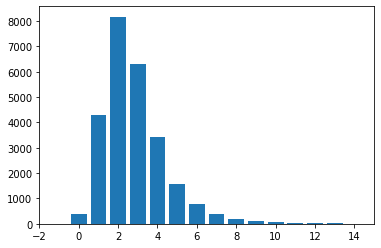

In [18]:
plt.bar(len_coauthor.value_counts().index,len_coauthor.value_counts().values)
plt.xlim([-2,15])
plt.show()

In [19]:
print(df.shape,y_features.shape)

(24380, 6) (24380, 100)


In [20]:
df_x = df[["year","venue", "coauthors", "abstract", "title"]]
df_x.head()

year  venue      coauthors  \
0     9     20        [13720]   
1    15      2  [1359, 15881]   
2    10      4             []   
3    10      9        [19617]   
4    18      0   [9641, 5623]   

                                            abstract  \
0  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
3  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   
4  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...   

                                               title  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
3  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...  
4  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...

In [21]:
print(df_x.shape,y_features.shape)

(24380, 5) (24380, 100)


In [22]:
### change the value in coauthor column with [] to 21246
def co_non(x):
  if len(x.values[0])!=0:
    return x
  else:
    x.values[0] = [21246]
    return x
df_x[['coauthors']] = df_x[['coauthors']].apply(lambda x: co_non(x),axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [23]:
df_x.head()

year  venue      coauthors  \
0     9     20        [13720]   
1    15      2  [1359, 15881]   
2    10      4        [21246]   
3    10      9        [19617]   
4    18      0   [9641, 5623]   

                                            abstract  \
0  [2455, 1858, 2335, 1543, 1800, 1860, 2000, 286...   
1  [40, 1542, 1691, 2449, 1535, 3616, 2206, 1904,...   
2  [46, 1624, 1547, 56, 1687, 1644, 6, 7, 3386, 1...   
3  [37, 3709, 3836, 1586, 2151, 1727, 3021, 1860,...   
4  [1731, 2021, 1543, 11, 1546, 11, 1647, 2163, 1...   

                                               title  
0  [41, 1550, 1563, 1594, 1544, 1919, 1644, 37, 1...  
1  [1731, 47, 11, 57, 4624, 1525, 1535, 47, 11, 3...  
2  [40, 1733, 1735, 1540, 1655, 46, 1624, 1547, 5...  
3  [38, 1592, 2088, 1543, 1574, 1727, 1597, 1813,...  
4  [1560, 1694, 11, 1546, 11, 3066, 1728, 47, 160...

## TF_IDF

In [24]:
def tf_idf(df, feature, num_features):
    import collections
    num_paper = df[[feature]].shape[0]
    lenmin = min(df[[feature]].apply(lambda x: min(x.values[0]) ,axis=1))
    lenmax = max(df[[feature]].apply(lambda x: max(x.values[0]) ,axis=1))
    initial_count = np.zeros([df[[feature]].shape[0],lenmax-lenmin+1])
    initial_have = np.zeros([df[[feature]].shape[0],lenmax-lenmin+1])
    count_each = df[[feature]].apply(lambda x: collections.Counter(x.values[0]),axis=1)
    df_count = pd.DataFrame(count_each)
    

    for i in range(df_count.shape[0]):
        keys = list(df_count.values[i][0].keys())
        values = list(df_count.values[i][0].values())
        initial_count[i,np.array(keys)-1] = values
        initial_have[i,np.array(keys)-1] = 1
    sum_length = np.tile(sum(initial_count.T).reshape(initial_count.shape[0],1),initial_count.shape[1])
    tf = initial_count/sum_length
    idf = np.log((num_paper)/(sum(initial_have)+1))
    result = tf*np.tile(idf,(initial_have.shape[0],1))
    select_top = -np.sort(-result,axis=1)[:,:num_features]
    final = []
    for i in range(df[[feature]].shape[0]):
      topk = []

      for j in range(num_features):
        t = np.where(result[i]==select_top[i][j])
        if len(t)!=1:
          for k in t[0].tolist():
            topk.append(k+1)
        else:
          topk.append(t[0].tolist()[0]+1)

      instance = df[feature].iloc[i]
      list1 = [item for item in instance if item in topk]
      df[feature].iloc[i] = list1


In [25]:
tf_idf(df_x, 'abstract', 95)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [26]:
tf_idf(df_x, 'title', 10)

In [27]:
print(max(df_x[['abstract']].apply(lambda x: max(x.values[0]),axis =1)))
print(min(df_x[['abstract']].apply(lambda x: min(x.values[0]),axis =1)))
print(max(df_x[['title']].apply(lambda x: max(x.values[0]),axis =1)))
print(min(df_x[['title']].apply(lambda x: min(x.values[0]),axis =1)))


4999
1
4996
1


In [28]:
y_features.shape

(24380, 100)

## Split training set and validation set

In [29]:
###split the training dataset to validation dataset and training dataset
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(df_x,y_features,test_size=0.2,random_state=2022)

In [30]:
### Concat X and Y 
def create_dataset(x,y):
  instances = []
  for i in range(x_val.shape[0]):
    instance = []
    instance.append(x.iloc[i,0])
    instance.append(x.iloc[i,1])
    instance.append(torch.tensor(x.iloc[i,2]))
    instance.append(torch.tensor(x.iloc[i,3]))
    instance.append(torch.tensor(x.iloc[i,4]))
    instances.append([np.array(instance),y.iloc[i,:].values])

  return instances

In [31]:
train = create_dataset(x_train,y_train)
val = create_dataset(x_val,y_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


In [32]:
### Convert the input data into a dictionary
def my_collate(data):
  years = []
  venue = []
  coauthors = []
  abstract = []
  title = []

  authors = []
  for paper, label in data:
    
    years.append(paper[0])
    venue.append(paper[1])
    
    coauthors.append(paper[2])
    abstract.append(paper[3])
    title.append(paper[4])
    authors.append(label.astype(int))
  return {'year':torch.tensor([years]),'venue':torch.tensor([venue]),'coauthors':coauthors,'abstract':abstract,'title':title,'author':authors}

In [42]:
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(2022) 
batch_size = 128
hidden_dim = 256

train_loader = DataLoader(train, batch_size=batch_size, collate_fn=my_collate, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, collate_fn=my_collate, shuffle=True)

In [34]:
year_num = 20
venue_num = 467
coauthor_num = 21248
word_num = 5000

# Model Architecture

## Deep ANN (Final approach)

In [35]:
import torch.nn.functional as F

HIDDEN_DIM1 = 256
HIDDEN_DIM2 = 256
HIDDEN_DIM3 = 256

class DeeepANNModel(nn.Module):
    
    def __init__(self, input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim, hidden_dim1 = HIDDEN_DIM1, hidden_dim2 = HIDDEN_DIM2, hidden_dim3 = HIDDEN_DIM3):
        super().__init__()
        
        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.sigmoid = nn.Sigmoid()

        self.input_layer = nn.Linear(input_dim, hidden_dim1)
        self.hidden_layer1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden_layer2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.output_layer = nn.Linear(hidden_dim3, output_dim)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year) #year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue) #venue embedding
        
        co = [] #coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = [] #abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = [] #title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1)
        
        out = F.relu(self.input_layer(all_embed))
        out = self.dropout(out)
                
        out = F.relu(self.hidden_layer1(out))
        out = self.dropout(out) 
        out = F.relu(self.hidden_layer2(out))
        out = self.dropout(out)  

        out = self.output_layer(out)
        #out = self.sigmoid(out)
        return out
        

In [36]:
def traindann(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())


        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss)  
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
            print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))

    return train_losses, f1_scores

In [38]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.01
weight_decay = 1e-8 

dann_model = DeeepANNModel(input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim)
optimizer = torch.optim.Adam(dann_model.parameters(), lr=learning_rate, weight_decay = weight_decay) 

danntrain_loss, dannf1_score = traindann(dann_model, optimizer, train_loader, num_epochs, input_dim, criterion)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  import sys


epoch: 5. Loss: 0.0509060817078138. f1_score: 0.2916666666666667
epoch: 10. Loss: 0.019532332125191506. f1_score: 0.7222222222222222
epoch: 15. Loss: 0.014681254585201923. f1_score: 0.7222222222222222
epoch: 20. Loss: 0.01441277401187481. f1_score: 0.8055555555555555
epoch: 25. Loss: 0.014406590209079858. f1_score: 0.75
epoch: 30. Loss: 0.014962172684952235. f1_score: 0.8888888888888888
epoch: 35. Loss: 0.018194361518208798. f1_score: 0.5
epoch: 40. Loss: 0.020651984458359387. f1_score: 0.6388888888888888
epoch: 45. Loss: 0.01867232598268833. f1_score: 0.9
epoch: 50. Loss: 0.018096583847625133. f1_score: 0.8101851851851851


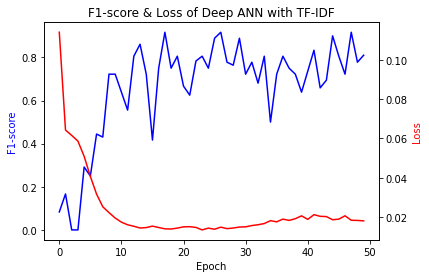

In [39]:
import numpy as np
import matplotlib.pyplot as plt
y1 = dannf1_score
y2 = danntrain_loss
 
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
ax1.plot(y1, 'b-')
ax2.plot(y2, 'r-')
 
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1-score', color='b')
ax2.set_ylabel('Loss', color='r')
plt.title('F1-score & Loss of Deep ANN with TF-IDF')
 
plt.show()

### Calculate F1 of validation set

In [ ]:
def valid(train_loader, model, criterion,batch_size):
  with torch.no_grad():
    val_batch_loss = []
    pred = []
    true = []
    for i, item in enumerate(train_loader):
      labels = torch.tensor(item['author']).float()
      model.eval()

      yhat = model(item)
      val_loss = criterion(yhat, labels)
      val_batch_loss.append(val_loss.item())

      c = yhat.cpu().detach().numpy()
      pred.append(np.where(c>0.5,1,0))
      true.append(labels.cpu().detach().numpy())

    from sklearn.metrics import f1_score
    val_result = np.zeros([batch_size*(len(pred)-1)+pred[-1].shape[0],100])
    val_true = np.zeros([batch_size*(len(true)-1)+true[-1].shape[0],100])
    for i,batch in enumerate(pred):
      for j,value in enumerate(batch):
        val_result[i*batch_size+j,:]=pred[i][j]
        val_true[i*batch_size+j,:]=true[i][j]
    f1score = f1_score(val_result, val_true, average='samples',zero_division=1)

  return f1score

In [ ]:
valid(val_loader, dann_model, criterion,batch_size)

### Adjust test set

In [ ]:
def test_adjust(test):

  test = pd.DataFrame(test)[['year','venue','coauthors','abstract','title']]
  test['venue'] = test[['venue']].apply(lambda x: x if x.values[0]!='' else 465,axis = 1)
  test[['coauthors']] = test[['coauthors']].apply(lambda x: co_non(x),axis=1)
  tf_idf(test, 'abstract', 95)
  tf_idf(test, 'title', 10)

  years = []
  venue = []
  coauthors = []
  abstract = []
  title = []

  for i in range(test.shape[0]):
    
    years.append(test.iloc[i,0])
    venue.append(test.iloc[i,1])
    
    coauthors.append(torch.tensor(test.iloc[i,2]))
    abstract.append(torch.tensor(test.iloc[i,3]))
    title.append(torch.tensor(test.iloc[i,4]))

  return {'year':torch.tensor([years]),'venue':torch.tensor([venue]),'coauthors':coauthors,'abstract':abstract,'title':title}

### Output CSV

In [ ]:
def testsol(test_data, model):
  #get prediction
  with torch.no_grad():
    model.eval()
    yhat_test = model(test_data)
    c_test = yhat_test.cpu().detach().numpy()
    pred_test = np.where(c_test>0.5,1,0)

  #adjust the form of soluton
  pred_list = []
  for i in range(pred_test.shape[0]):
    if(len(np.where(pred_test[i]==1)[0])==0):
      pred_list.append(np.array([-1]))  
    else:
      pred_list.append(np.where(pred_test[i]==1))  

  #output the solution      
  test_result = pd.DataFrame(np.array(pred_list))
  test_result[0] = test_result[0].map(str).apply(lambda x: x.replace('[','').replace(']',''))
  test_result.to_csv('sol.csv')

In [ ]:
# test = pd.DataFrame(load_dict_test)[['year','venue','coauthors','abstract','title']]
# test['venue'] = test[['venue']].apply(lambda x: x if x.values[0]!='' else 465,axis = 1)
# test[['coauthors']] = test[['coauthors']].apply(lambda x: co_non(x),axis=1)

In [ ]:
test_data = test_adjust(load_dict_test)
testsol(test_data, dann_model)

## One layer Neural network Architecture

In [ ]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim):
        super(ANNModel, self).__init__()

        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.fc1 = nn.Linear(input_dim, output_dim) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1)
        out = self.fc1(all_embed)
        #out = self.sigmoid(out)
        return out

In [ ]:
def trainann(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            # adjust the batch size
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())


        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss)  
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
            print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))

    return train_losses, f1_scores

In [ ]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 50
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.005
weight_decay = 1e-8 

ann_model1 = ANNModel(input_dim, embed_year, embed_venue, embed_co, embed_word, output_dim)
optimizer = torch.optim.Adam(ann_model1.parameters(), lr=learning_rate, weight_decay=weight_decay) 


anntrain_loss, annf1_score = trainann(ann_model1, optimizer, train_loader, num_epochs, input_dim, criterion)

In [ ]:
valid(val_loader, ann_model1, criterion)

In [ ]:
testsol(test_data, ann_model1)

## RNN

In [40]:
class RNNModel(nn.Module):
    def __init__(self,embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1).view(-1,1,input_dim)

        h0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()

        out, h0 = self.rnn(all_embed, h0.detach())
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [46]:
def trainrnn(model, optimizer, train_loader, num_epochs,input_dim, criterion):
    train_losses = []
    f1_scores = []
    for epoch in range(num_epochs):
        batch_loss = []  
        for i, item in enumerate(train_loader):
            # adjust the batch size
            labels = torch.tensor(item['author']).float()

            optimizer.zero_grad()
 
            predictions = model(item)
            loss = criterion(predictions, labels)
            loss.backward()

            optimizer.step()
            batch_loss.append(loss.item())

        train_loss = np.mean(batch_loss)
        train_losses.append(train_loss) 
        c = predictions.cpu().detach().numpy()
        pred = np.where(c>0.5,1,0)
        from sklearn.metrics import f1_score
        f1score = f1_score(labels, pred, average='samples', zero_division=1)
        f1_scores.append(f1score)

        if (epoch+1) % 5 == 0:
            print('epoch: {}. Loss: {}. f1_score: {}'.format(epoch+1, train_loss, f1score))  


    return train_losses, f1_scores

In [47]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 100
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
layer_dim = 3
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
weight_decay = 1e-8 

rnn_model = RNNModel(embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


rnn_train_loss, rnn_f1_loss = trainrnn(rnn_model, optimizer, train_loader, num_epochs, input_dim, criterion)

epoch: 5. Loss: 4.182931239788349. f1_score: 0.35324074074074074
epoch: 10. Loss: 4.124238197620098. f1_score: 0.7599206349206349
epoch: 15. Loss: 4.088831510299292. f1_score: 0.6059523809523809
epoch: 20. Loss: 4.054226429034502. f1_score: 0.8888888888888888
epoch: 25. Loss: 4.0596555929917555. f1_score: 0.8055555555555555
epoch: 30. Loss: 4.07041640770741. f1_score: 0.7472222222222222
epoch: 35. Loss: 4.048134528673613. f1_score: 0.9444444444444443
epoch: 40. Loss: 4.057198970745771. f1_score: 0.9166666666666666
epoch: 45. Loss: 4.032622416814168. f1_score: 0.8333333333333334
epoch: 50. Loss: 4.023619535641792. f1_score: 0.875
epoch: 55. Loss: 4.037405344156118. f1_score: 0.9444444444444443
epoch: 60. Loss: 4.0368140294001655. f1_score: 1.0
epoch: 65. Loss: 4.031701583128709. f1_score: 0.8888888888888888
epoch: 70. Loss: 4.015577194018242. f1_score: 0.9722222222222222
epoch: 75. Loss: 4.1395030327332325. f1_score: 0.430952380952381
epoch: 80. Loss: 4.108699615185078. f1_score: 0.2736

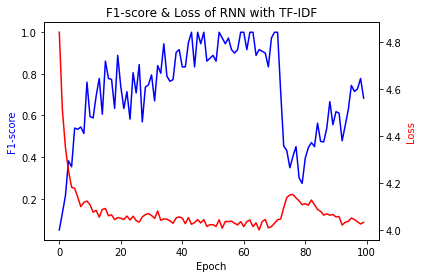

In [48]:
import numpy as np
import matplotlib.pyplot as plt
y1 = rnn_f1_loss
y2 = rnn_train_loss
 
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
ax1.plot(y1, 'b-')
ax2.plot(y2, 'r-')
 
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1-score', color='b')
ax2.set_ylabel('Loss', color='r')
plt.title('F1-score & Loss of RNN with TF-IDF')
 
plt.show()

In [ ]:
valid(val_loader, rnn_model, criterion)

In [ ]:
test_data = test_adjust(load_dict_test)

In [ ]:
testsol(test_data, rnn_model)

## LSTM

In [49]:
class LSTMModel(nn.Module):
    def __init__(self,embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        self.yembed = nn.Embedding(year_num, embed_year)
        self.vembed = nn.Embedding(venue_num, embed_venue)
        self.coembed = nn.Embedding(coauthor_num, embed_co)
        self.wordembed = nn.Embedding(word_num, embed_word)

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        year = x['year']
        venue = x['venue']
        coauthor = x['coauthors']
        abstract = x['abstract']
        title = x['title']

        y = self.yembed(year).view(-1,embed_year)#year embedding
        #y = year.view(year.size()[1],-1)
        v = self.vembed(venue).view(-1,embed_venue)#venue embedding
        
        co = []#coauthor embedding
        for i in coauthor:
          co_ins = self.coembed(i.int())
          co.append(co_ins.mean(dim=0))
        final_co = torch.stack(co)

        ab = []#abstract embedding
        for j in abstract:
          ab_ins = self.wordembed(j.int())
          ab.append(ab_ins.mean(dim=0))
        final_ab = torch.stack(ab)

        ti = []#title embedding
        for k in title:
          ti_ins = self.wordembed(k.int())
          ti.append(ti_ins.mean(dim=0))
        final_ti = torch.stack(ti)
        
        
        all_embed = torch.cat((y,v,final_co,final_ab,final_ti),dim=-1).view(-1,1,input_dim)

        h0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, year.size()[1], self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(all_embed, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [51]:
embed_year, embed_venue, embed_co, embed_word = 10, 50, 200, 100
num_epochs = 100
input_dim = embed_year+embed_venue+embed_co+embed_word+embed_word
output_dim = 100
layer_dim = 3
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
weight_decay = 1e-8 

lstm_model = LSTMModel(embed_year, embed_venue, embed_co, embed_word, input_dim, hidden_dim, layer_dim, output_dim)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate, weight_decay=weight_decay) 


lstm_train_loss, lstm_f1_loss = trainrnn(lstm_model, optimizer, train_loader, num_epochs, input_dim, criterion)

epoch: 5. Loss: 4.38025811390999. f1_score: 0.14729706209969368
epoch: 10. Loss: 4.165895975553072. f1_score: 0.24485329485329485
epoch: 15. Loss: 4.12718618221772. f1_score: 0.65
epoch: 20. Loss: 4.083021634664291. f1_score: 0.5333333333333333
epoch: 25. Loss: 4.06893251492427. f1_score: 0.3638888888888889
epoch: 30. Loss: 4.090064739569639. f1_score: 0.6333333333333333
epoch: 35. Loss: 4.088509688010583. f1_score: 0.6472222222222223
epoch: 40. Loss: 4.066988070805867. f1_score: 0.6666666666666666
epoch: 45. Loss: 4.061386786974394. f1_score: 0.6444444444444445
epoch: 50. Loss: 4.058685357754047. f1_score: 0.8305555555555554
epoch: 55. Loss: 4.068484752606123. f1_score: 0.7499999999999999
epoch: 60. Loss: 4.0509754327627325. f1_score: 0.7611111111111111
epoch: 65. Loss: 4.058765069032327. f1_score: 0.736111111111111
epoch: 70. Loss: 4.063538117286487. f1_score: 0.8333333333333334
epoch: 75. Loss: 4.066256089088244. f1_score: 0.8333333333333331
epoch: 80. Loss: 4.0822460529131765. f1_s

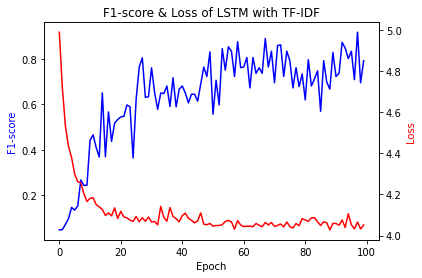

In [53]:
import numpy as np
import matplotlib.pyplot as plt
y1 = lstm_f1_loss
y2 = lstm_train_loss
 
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
ax1.plot(y1, 'b-')
ax2.plot(y2, 'r-')
 
ax1.set_xlabel('Epoch')
ax1.set_ylabel('F1-score', color='b')
ax2.set_ylabel('Loss', color='r')
plt.title('F1-score & Loss of LSTM with TF-IDF')
 
plt.show()

In [ ]:
valid(val_loader, lstm_model, criterion)

In [ ]:
test_data = test_adjust(load_dict_test)

In [ ]:
testsol(test_data, lstm_model)